# One-Hot Encoded Char-Level Recurrent Model

Using the balanced data. Testing for cheating in various ways.

Set whether the model looks at abstracts or titles here:

In [ ]:
# 'abstract' or 'title'
text_field = 'title'd

# Imports and Setup

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab
!pip install wandb pytorch-lightning unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn


import math
import pandas as pd
import numpy as np
import torch
pd.set_option(u'float_format', '{:f}'.format)

# pl and wandb installation and setup.
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


Google drive access

In [ ]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import models, loaders, and utility functions from our external package:

In [ ]:
import arxiv_vixra_models as avm

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n",f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

Not connected to a GPU
Memory
--------------------------------------------------
 Your runtime has 13.6 gigabytes of available RAM
 

CPU
--------------------------------------------------
 CPU Processors: 2


Copy data to CWD and read in with pandas.

In [ ]:
# Copy data and dictionary of chars to cwd
train_data_file_name = 'balanced_filtered_normalized_data_randomized_source_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
chars_file_name = 'normalized_char_set.feather'
chars_path = FOLDERNAME + SUBDIR + chars_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{chars_path}' .

In [ ]:
# load with pd
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
chars_df = pd.read_feather(chars_file_name)

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.  **If the notebook 

In [ ]:
from requests import get
project_str = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
project_str = project_str.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(project_str)

balanced_one-hot-char_recurrent_cheating_tests


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[text_field], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

                                                                                         title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                 title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    abstract source
0                             

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
# Data was prepared with a max of 2048 chars for abstracts16 and 128 for titles.
seq_len = 2048 if text_field == 'abstract' else 128
model_args_dic = {'seq_len': seq_len,
              'num_layers': 2,
              'bidirectional': True,
              'rnn_type': 'GRU',
              'hidden_size': 128,
              'dropout': None,
              }
# The batch size we set here determines the number of datapoints used
# in the histogram that avm.WandbOneHotTextCallback logs
data_args_dic = {'seq_len': seq_len,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'chars': chars_df, 
                 'text_column': text_field,
                 'num_workers': num_processors,
                 'batch_size': 512,
                 'pin_memory': is_cuda_available,
                 'persistent_workers': True
                 }

Small test run.

In [ ]:
small_example_data_module = avm.OneHotCharDataModule(**{**data_args_dic, **{'sample_size': data_args_dic['batch_size']}})
small_example_data_module.setup()
small_example_loader = small_example_data_module.train_dataloader()
small_example_inputs, small_example_targets = next(iter(small_example_loader))
# Print the first few input texts
for tensor, source in zip(small_example_inputs[:3], small_example_targets[:3]):
    stripped_text = avm.one_hot_decoding(tensor, chars_file_name)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
# Test the model        
small_example_model = avm.LitOneHotCharRecurrent(input_size=len(chars_df),
                                             **model_args_dic)
small_example_preds, small_example_losses, _ = small_example_model.preds_losses_hiddens(small_example_inputs, small_example_targets)
print('\npreds shape:', small_example_preds.shape, '\n')
print('\nactual loss:', small_example_losses.item(), '\n')
print('\nexpected approx loss', -math.log(.5), '\n')

text: acoustic spectroscopy of the dna in ghz range
len: 45
source: 0
text: how laser start from chaos
len: 26
source: 0
text: investigating causality in human behavior from smartphone sensor data : a quasi - experimental approach
len: 103
source: 0

preds shape: torch.Size([512, 1]) 


actual loss: 0.6940315961837769 


expected approx loss 0.6931471805599453 



For logging purposes, take another sample from the validation set which will be be used to visualize predictions.

In [ ]:
val_sample  = next(iter(small_example_data_module.val_dataloader()))
val_sample_text = [avm.one_hot_decoding(input, chars_file_name) for input in val_sample[0]]
print(*val_sample_text[:3], sep='\n')

determining interface dielectric losses in superconducting coplanar waveguide resonators
zero and negative energy dissipation at information - theoretic erasure
seir and regression model based covid - 19 outbreak predictions in india


# Single, Local Model Training

Train a single model with the hyperparameters chosen in `data_args_dic` and `model_args_dic` which we can then feed examples.

In [ ]:
local_model_args_dic = {'seq_len': seq_len,
              'num_layers': 2,
              'bidirectional': True,
              'rnn_type': 'GRU',
              'truncated_bptt_steps': 128,
              'hidden_size': 128,
              'dropout': None,
              'lr': 1e-3
              }

local_data_args_dic = {**data_args_dic,
                       **{'batch_size': 512,}
                       }

local_trainer_dic = {'gpus': -1 if is_cuda_available else 0,
                     'logger': WandbLogger(),
                     'max_epochs': 8,
                     'stochastic_weight_avg': True,
                     'callbacks': [avm.WandbOneHotTextCallback(val_sample=val_sample,
                                                               chars=chars_df,
                                                               labels=('arxiv', 'vixra'))],
                     'log_every_n_steps': 5,                 
               }
# Uncomment to sync run results with wandb.
wandb.init(project=project_str,
           config=local_model_args_dic,
           group='Randomized Source Tests',
           name='Randomized Train',
           )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type     | Params
-----------------------------------------
0 | train_acc   | Accuracy | 0     
1 | val_acc     | Accuracy | 0     
2 | test_acc    | Accuracy | 0     
3 | rnn         | GRU      | 449 K 
4 | class_layer | Linear   | 257   
-----------------------------------------
449 K     Trainable params
0         Non-trainable params
449 K     Total params
1.798     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

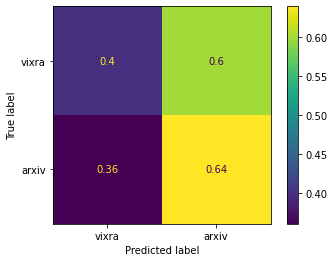

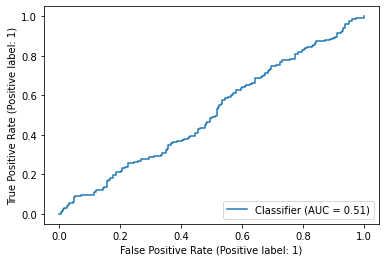

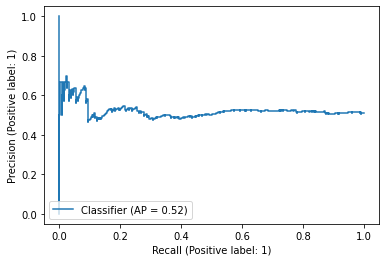

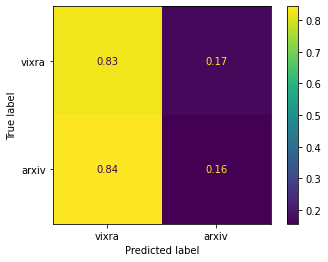

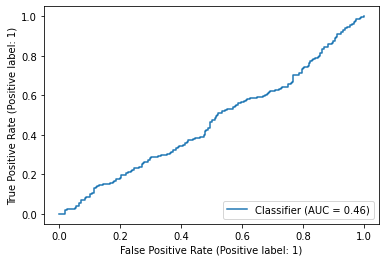

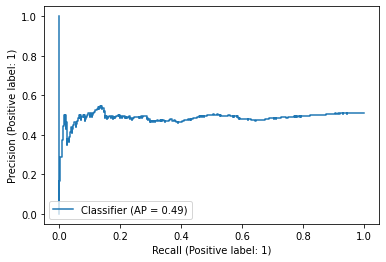

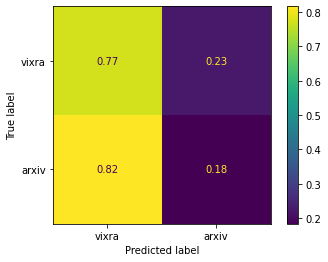

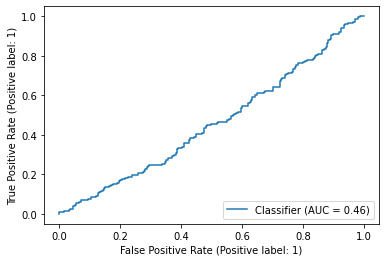

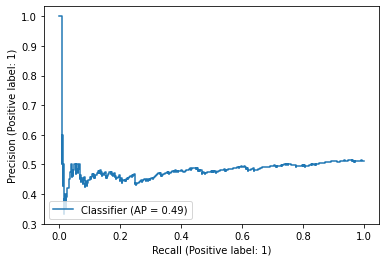

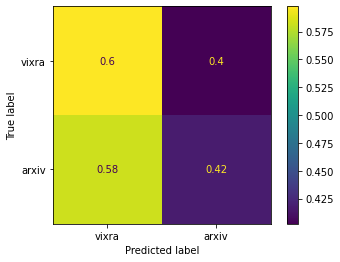

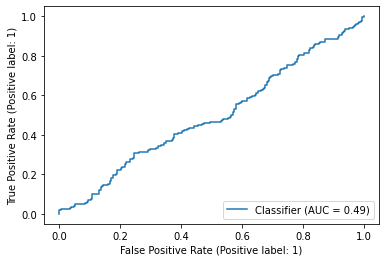

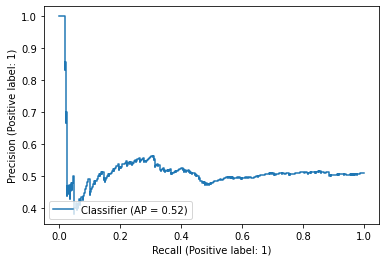

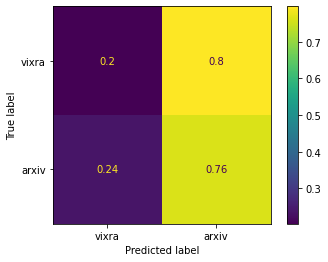

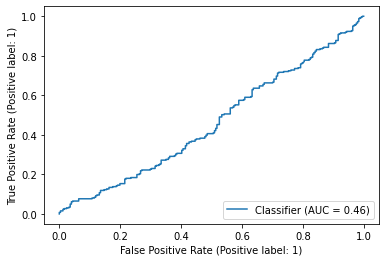

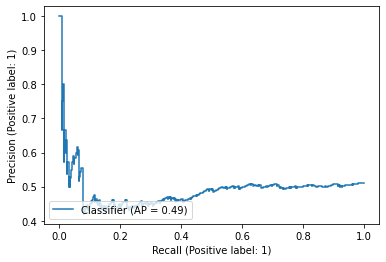

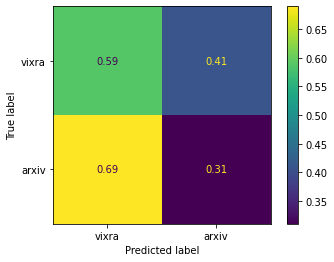

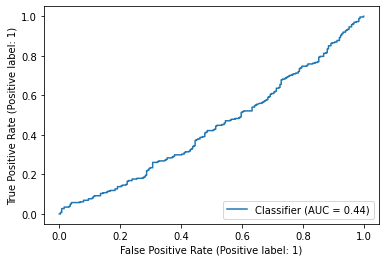

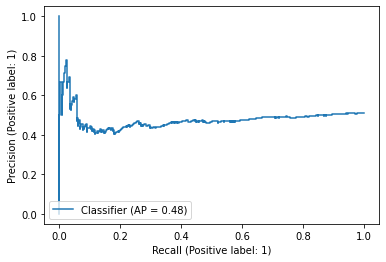

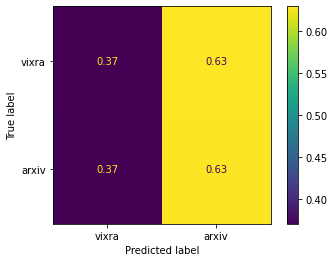

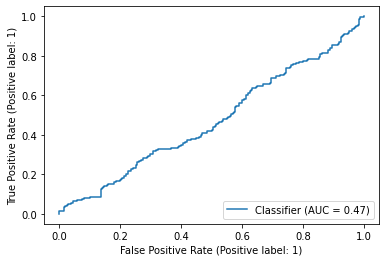

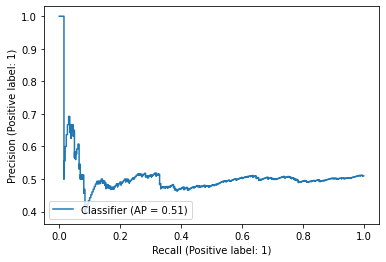

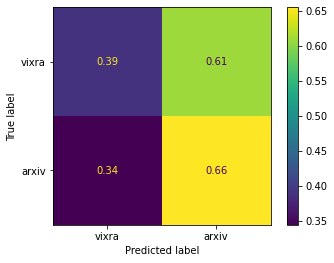

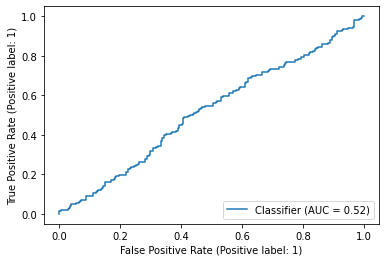

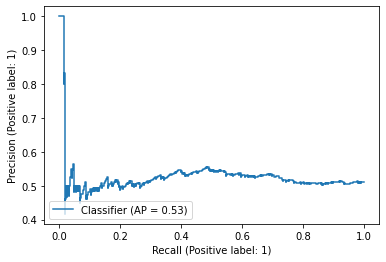

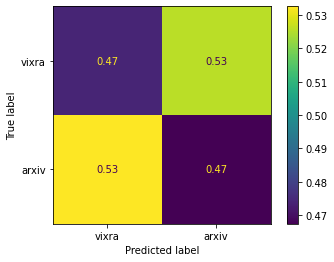

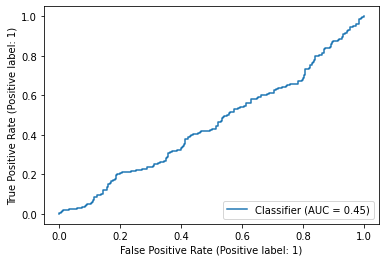

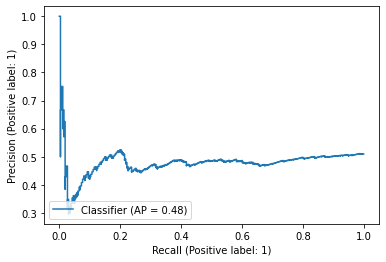

In [ ]:
local_data_module = avm.OneHotCharDataModule(**local_data_args_dic)
local_model = avm.LitOneHotCharRecurrent(input_size=len(chars_df),
                                         **local_model_args_dic)
local_trainer = Trainer(**local_trainer_dic)
local_trainer.fit(local_model, datamodule=local_data_module)

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyperparam_dic`.
* `fixed_hyperparam_dic` is eventually merged with the hyperparameter dictionary for those hyperparameters included in `sweep_config` which is generated by `wandb`, with the result passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.

In [ ]:
fixed_hyperparam_dic = {'seq_len': seq_len,
                        'rnn_type': 'GRU',
                        'num_layers': 2,
                        'bidirectional': True,
                        'hidden_size': 128,
                        'truncated_bptt_steps': None,
                        'save_best_models_wandb': False,
                        'dropout': None
                        }

sweep_config = {'method': 'random',

                'early_terminate': {'type': 'hyperband',
                                    'min_iter': 3
                                    },
                'metric': {'name': 'val_loss',
                           'goal': 'minimize'
                           },
                'parameters': {'lr': {'distribution': 'log_uniform',
                                      'min': math.log(1e-4),
                                      'max': math.log(1e-2)
                                      }
                               },
                }   

[autoreload of arxiv_vixra_models.callbacks failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'pl' is not defined
]


Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyperparam_dic` for logging purposes.

In [ ]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyperparam_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyperparam_dic['batch_size'] = 64 #2 **10

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 8,
               'stochastic_weight_avg': True
               }
fixed_hyperparam_dic = {**fixed_hyperparam_dic, **trainer_dic}
def sweep_iteration():
    # Group by various properties
    group_str_elements = [fixed_hyperparam_dic['rnn_type'],
                          f"{'-bidirectional' if fixed_hyperparam_dic['bidirectional'] else ''}",
                          f"-hidden_size_{fixed_hyperparam_dic['hidden_size']}"
                          f"-{fixed_hyperparam_dic['num_layers']}_layers",
                          f"-{fixed_hyperparam_dic['max_epochs']}_epochs"]
    group_str = ''.join(group_str_elements)
    with wandb.init(group=group_str) as run:
        data = avm.OneHotCharDataModule(**data_args_dic)
        config = wandb.config
        # Merge config with model_args_dic
        config = {**fixed_hyperparam_dic, **config}
        # Passing wandb.config to the Model passes the `parameters` key from sweep_config.
        model = avm.LitOneHotCharRecurrent(input_size=len(chars_df), **config)
        # Overwrite the random run names chosen by wandb.
        name_str_elements = [f"lr_{config['lr']:.3E}",
                             f"{'-dropout_' + str(config['dropout']) if config['dropout'] else ''}"]
        name_str = ''.join(name_str_elements)
        run.name = name_str
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[avm.WandbOneHotTextCallback(val_sample=val_sample,
                                                   chars=chars_df,
                                                   labels=('arxiv', 'vixra'))],
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_str)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 5s6tnk10
Sweep URL: https://wandb.ai/garrett361/balanced_abstract_one-hot-char_recurrent/sweeps/5s6tnk10


In [ ]:
wandb.agent(sweep_id, project=project_str, function=sweep_iteration)